In [ ]:
!pip install biopython
!pip install  networkx
!pip install biopandas
!pip install dgl
!pip install torch_geometric




from Bio import PDB
from collections import defaultdict
import numpy as np
import numpy as np

from biopandas.pdb import PandasPdb
from torch_geometric.data import Data,DataLoader
from torch_geometric.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import dgl
import numpy as np
import random
import matplotlib.pyplot as plt
import requests
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.9 MB/s eta 0:00:00


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
#the dataset saved in numpy array conatins
#Protein1 id  ; protein 2 id ; 0 or 1

dataset = np.load('dataset.npy', allow_pickle=True)
protein_1 = dataset[:,2]
protein_2 = dataset[:,5]
label = dataset[:,6].astype(float)

In [ ]:
print(label)

[1. 1. 1. ... 0. 0. 1.]


In [ ]:
#Download the pdf files from the rcsb api
# if you want to download all the pdbs use
# list(pdbs=set(protein_1).union(set(protein_2)))


def download_pdb_files(pdb_ids, destination_folder):
    base_url = "https://files.rcsb.org/download/"

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    index=0
    for pdb_id in pdb_ids:
        print(index)
        index+=1
        url = f"{base_url}{pdb_id.upper()}.pdb"
        file_path = os.path.join(destination_folder, f"{pdb_id.upper()}.pdb")

        response = requests.get(url)
        if response.status_code == 200:
            with open(file_path, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded: {pdb_id}")
        else:
            print(f"Failed to download: {pdb_id} (Status Code: {response.status_code})")

# Example: Download PDB files for proteins with IDs 1abc and 1xyz
pdb_ids_to_download = pdbs
download_destination = 'pdbs'
download_pdb_files(pdb_ids_to_download, download_destination)


In [ ]:
def load_pickle(path):
  v=None
  with open(path, 'rb') as file:
    v=pickle.load(file)
    return v
def save_pickle(path,var):
  with open(path, 'wb') as file:
    pickle.dump(var, file)


#to execute when finishing and saving evrything to drive
#to save the adjancy and embeddings dict
# save_pickle('adj_dict.pkl',adj_dict)
# save_pickle('embed_dict.pkl',embed_dict)
#copy the preprocessed pdbs from drive
# !cp *.pkl ./drive/MyDrive


In [ ]:
# import pdbs from drive or you  can download them using download_pdb_files function
# !cp -r ./drive/MyDrive/pdbs .
# !cp ./drive/MyDrive/*.pkl  .
#read the files
adj_dict=load_pickle('adj_dict.pkl')
embed_dict=load_pickle('embed_dict.pkl')

In [ ]:
#import the pdbs folder from drive
!cp -r ./drive/MyDrive/pdbs .

In [ ]:
#Amino acids embeddings from the paper researchers Github
pcp_dict = {'ALA':[ 0.62014, -0.18875, -1.2387, -0.083627, -1.3296, -1.3817, -0.44118],
            'CYS':[0.29007, -0.44041,-0.76847, -1.05, -0.4893, -0.77494, -1.1148],
            'ASP':[-0.9002, 1.5729, -0.89497, 1.7376, -0.72498, -0.50189, -0.91814],
            'GLU':[-0.74017, 1.5729, -0.28998, 1.4774, -0.25361, 0.094051, -0.4471],
            'PHE':[1.1903, -1.1954, 1.1812, -1.1615, 1.1707, 0.8872, 0.02584],
            'GLY':[ 0.48011, 0.062916, -1.9949, 0.25088, -1.8009, -2.0318, 2.2022],
            'HIS':[-0.40009, -0.18875, 0.17751, 0.77123, 0.5559, 0.44728, -0.71617],
            'ILE':[1.3803, -0.84308, 0.57625, -1.1615, 0.10503, -0.018637, -0.21903],
            'LYS':[-1.5003, 1.5729, 0.75499, 1.1057, 0.44318, 0.95221, -0.27937],
            'LEU':[1.0602, -0.84308, 0.57625, -1.273, 0.10503, 0.24358, 0.24301],
            'MET':[0.64014, -0.59141, 0.59275, -0.97565, 0.46368, 0.46679, -0.51046],
            'ASN':[-0.78018, 1.0696, -0.38073, 1.2172, -0.42781, -0.35453, -0.46879],
            'PRO':[0.12003, 0.062916, -0.84272, -0.1208, -0.45855, -0.75977, 3.1323],
            'GLN':[-0.85019, 0.16358, 0.22426, 0.8084, 0.04355, 0.24575, 0.20516],
            'ARG':[-2.5306, 1.5729, 0.89249, 0.8084, 1.181, 1.6067, 0.11866],
            'SER':[-0.18004, 0.21392, -1.1892, 0.32522, -1.1656, -1.1282, -0.48056],
            'THR':[-0.050011, -0.13842, -0.58422, 0.10221, -0.69424, -0.63625, -0.50017],
            'VAL':[1.0802, -0.69208, -0.028737, -0.90132, -0.36633, -0.3762, 0.32502],
            'TRP':[0.81018, -1.6484, 2.0062, -1.0872, 2.3901, 1.8299, 0.032377],
            'TYR':[0.26006, -1.0947, 1.2307, -0.78981, 1.2527, 1.1906, -0.18876]}

In [ ]:
#The function that parses the pdb files to adjancy matrix of amino acids

aa_set = set([
        'ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE',
        'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL',
    ])



def pdb_to_adjacency_matrix(pdb_file):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)

    amino_acids = {}
    amino_acid_index = 0

    atom_coordinates = []

    for model in structure:
        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue):
                    amino_acid = f"{residue.get_resname()}_{chain.id}_{residue.id[1]}"
                    if amino_acid not in amino_acids:
                        amino_acids[amino_acid] = amino_acid_index
                        amino_acid_index += 1

                    for atom in residue:
                        if atom.name in {'N', 'CA', 'C', 'O'}:
                            atom_coordinates.append(atom.coord)

    num_amino_acids = len(amino_acids)
    adjacency_matrix = np.zeros((num_amino_acids, num_amino_acids), dtype=int)

    for i in range(num_amino_acids):
        for j in range(i + 1, num_amino_acids):
            distance = np.linalg.norm(atom_coordinates[i] - atom_coordinates[j])
            if distance < 10.0:
                adjacency_matrix[i, j] = 1
                adjacency_matrix[j, i] = 1
    embed=[]
    for i in amino_acids.keys():
        if i[:3] in aa_set:
            embed.append(pcp_dict[i[:3]])
        else:embed.append([0]*7)

    return adjacency_matrix, embed




In [ ]:
#create dataset from availiable pdbs (filter failed to download)
# use this to create dataset from tha all the pdbs availiable in pdbs folder availiable=[i[:4]for i in os.listdir('pdbs')]

import os
#create dataset from only preprocessed pdbs
availiable=[i[:4]for i in adj_dict]
n=len(protein_1)
p1=[]
p2=[]
labels=[]
for i in range(n):
    if protein_1[i] in availiable and protein_2[i] in availiable:
        p1.append(protein_1[i])
        p2.append(protein_2[i])
        labels.append(label[i])

3711

In [ ]:
#skip this if you choose to use the  reprocessed
needed=set(p1).union(set(p2))
# adj_dict={}
# embed_dict={}
j=0
for i in list(needed)[1012:]:
    if i not in adj_dict:
      a,b=pdb_to_adjacency_matrix('pdbs/'+i+'.pdb')
      adj_dict[i]=torch.tensor(a).int().nonzero().t()
      embed_dict[i]=torch.tensor(b)
      print(j)
      j+=1

In [ ]:
# to ensure that all the tensors are in nonzero format
for i in adj_dict:
  if adj_dict[i].shape[0]>2:
    adj_dict[i]=torch.tensor(adj_dict[i]).int().nonzero().t()

In [ ]:

protein_1=[]
protein_2=[]
protein_embed_1=[]
protein_embed_2=[]
for i,j in zip(p1,p2):
    protein_1.append(adj_dict[i])
    protein_embed_1.append(embed_dict[i])
    protein_2.append(adj_dict[j])
    protein_embed_2.append(embed_dict[j])


In [ ]:
protein_embed_1 = [torch.tensor(i).float() for i in protein_embed_1]
protein_embed_2 = [torch.tensor(i).float() for i in protein_embed_2]

<ipython-input-16-1cc5120ea638>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_embed_1 = [torch.tensor(i).float() for i in protein_embed_1]
<ipython-input-16-1cc5120ea638>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_embed_2 = [torch.tensor(i).float() for i in protein_embed_2]


In [ ]:
batch_1 = [torch.zeros(i.shape[0]).to(torch.int64) for i in protein_embed_1]
batch_2 = [torch.ones(i.shape[0]).to(torch.int64) for i in protein_embed_2]

In [ ]:
labels=torch.tensor(labels)

# Model 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool

class ProteinComparer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ProteinComparer, self).__init__()
        self.conv = GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))
        self.fc = nn.Linear(128, output_dim)

    def forward(self, adj1, adj2, embedding1, embedding2):
        # Graph 1
        x1 = self.conv(embedding1, adj1)
        x1 = global_add_pool(x1, torch.zeros_like(embedding1[:, 0], dtype=torch.long))

        # Graph 2
        x2 = self.conv(embedding2, adj2)
        x2 = global_add_pool(x2, torch.zeros_like(embedding2[:, 0], dtype=torch.long))

        # Concatenate or perform any operation you need to compare the two graphs
        x_combined = torch.cat([x1, x2], dim=1)

        # Fully connected layer
        output = self.fc(x_combined)

        # Apply sigmoid activation using F.sigmoid
        output = output

        return output

# Instantiate the model
input_dim = 7  # Dimension of node embeddings
hidden_dim = 64  # Hidden dimension in GNN layers
output_dim = 1  # Output dimension, 1 for binary classification
model = ProteinComparer(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)


In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model.train()
hist=[]

for k in range(100):
  loss1=0
  ids=[random.randint(0,3200) for _ in range(64)]
  for i in ids:
    adj1=protein_1[i]
    adj2=protein_2[i]
    emb1=protein_embed_1[i]
    emb2=protein_embed_2[i]
    optimizer.zero_grad()

    output = model(adj1, adj2, emb1, emb2)
    loss = criterion(output, labels[i].view(-1, 1).float())
    loss.backward()
    optimizer.step()
    loss1+=loss.item()
  j=j+1
  hist.append(loss1)



In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist)

In [ ]:
res=0
model.eval()
for i in range(400):
  adj1=protein_1[i]
  adj2=protein_2[i]
  emb1=protein_embed_1[i]
  emb2=protein_embed_2[i]
  output = model(adj1, adj2, emb1, emb2).detach()
  # print(f"Sample {i + 1}: True Label = {labels[i].item()}, Predicted Label = {output[0][0].item()}")
  pred=0 if output[0][0].item()<0 else 1
  res+= 1 if labels[i].item() == pred else 0

print(res/400)


0.05


# Attention GNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_max_pool as gmp, global_add_pool as gap,global_mean_pool as gep,global_sort_pool
from torch_geometric.utils import dropout_adj
from torch.optim.lr_scheduler import MultiStepLR

class AttGNN(nn.Module):
    def __init__(self, n_output=1, num_features_pro= 1024, output_dim=128, dropout=0.1, heads = 1 ):
        super(AttGNN, self).__init__()

        print('AttGNN Loaded')

        self.hidden = 8
        self.heads = 1

        # for protein 1
        self.pro1_conv1 = GATConv(num_features_pro, self.hidden* 16, heads=self.heads, dropout=0.2)
        self.pro1_fc1 = nn.Linear(128, output_dim)


        # for protein 2
        self.pro2_conv1 = GATConv(num_features_pro, self.hidden*16, heads=self.heads, dropout=0.2)
        self.pro2_fc1 = nn.Linear(128, output_dim)

        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)
        # combined layers
        self.fc1 = nn.Linear(output_dim*3, 256)
        self.fc2 = nn.Linear(256, 64)
        self.out = nn.Linear(64, n_output)



    def forward(self, pro1_data, pro2_data):

        # get graph input for protein 1
        pro1_x, pro1_edge_index, pro1_batch = pro1_data.x, pro1_data.edge_index, pro1_data.batch
        # get graph input for protein 2
        pro2_x, pro2_edge_index, pro2_batch = pro2_data.x, pro2_data.edge_index, pro2_data.batch


        x = self.pro1_conv1(pro1_x, pro1_edge_index)
        x = self.relu(x)

	# global pooling
        x = gep(x, pro1_batch)

        # flatten
        x = self.relu(self.pro1_fc1(x))
        x = self.dropout(x)



        xt = self.pro2_conv1(pro2_x, pro2_edge_index)
        xt = self.relu(self.pro2_fc1(xt))

	# global pooling
        xt = gep(xt, pro2_batch)

        # flatten
        xt = self.relu(xt)
        xt = self.dropout(xt)

	# Concatenation
        xc = torch.cat((x, xt), 0)
        xc=xc.flatten()

        # add some dense layers
        xc = self.fc1(xc)
        # xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        # xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        out = self.sigmoid(out)
        return out


In [ ]:
attgnn=AttGNN(num_features_pro=7)

AttGNN Loaded


In [ ]:

optimizer = optim.Adam(attgnn.parameters())
criterion = nn.MSELoss()

In [ ]:
import random
attgnn.train()
hist=[]

for k in range(100):
  loss1=0
  ids=[random.randint(0,3200) for _ in range(64)]
  for i in ids:
    pr1=Data(x=protein_embed_1[i],edge_index=protein_1[i],batch=batch_1[i])
    pr2=Data(x=protein_embed_2[i],edge_index=protein_2[i],batch=batch_2[i])
    optimizer.zero_grad()
    output = attgnn(pr1,pr2)
    loss = criterion(output, torch.tensor([labels[i]]).float())
    loss.backward()
    optimizer.step()
    loss1+=loss.item()
  print(f"epoch {k}  sum of loss {loss1}")
  hist.append(loss1)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist)

In [ ]:
#eval
res=0
attgnn.eval()
for i in range(3200,3500):
  pr1=Data(x=protein_embed_1[i],edge_index=protein_1[i],batch=batch_1[i])
  pr2=Data(x=protein_embed_2[i],edge_index=protein_2[i],batch=batch_2[i])
  output = attgnn(pr1,pr2).detach()
  # print(f"Sample {i + 1}: True Label = {labels[i].item()}, Predicted Label = {output[0][0].item()}")
  pred= output.item()>0
  res+=  labels[i].item() == pred

print(res/300)

# CONV GNN

In [ ]:
# Building model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_max_pool as gmp, global_add_pool as gap,global_mean_pool as gep,global_sort_pool
from torch_geometric.utils import dropout_adj
from torch.optim.lr_scheduler import MultiStepLR



class GCNN(nn.Module):
    def __init__(self, n_output=1, num_features_pro= 7, output_dim=128, dropout=0.03):
        super(GCNN, self).__init__()

        print('GCNN Loaded')

        # for protein 1
        self.n_output = n_output
        self.pro1_conv1 = GCNConv(num_features_pro, num_features_pro)
        self.pro1_fc1 = nn.Linear(num_features_pro, output_dim)

        # for protein 2
        self.pro2_conv1 = GCNConv(num_features_pro, num_features_pro)
        self.pro2_fc1 = nn.Linear(num_features_pro, output_dim)

        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

        # combined layers
        self.fc1 = nn.Linear(3 * output_dim, 256)
        self.fc2 = nn.Linear(256 ,64)
        self.out = nn.Linear(64, self.n_output)

    def forward(self, pro1_data, pro2_data):

        #get graph input for protein 1
        pro1_x, pro1_edge_index, pro1_batch = pro1_data.x, pro1_data.edge_index, pro1_data.batch
        # get graph input for protein 2
        pro2_x, pro2_edge_index, pro2_batch = pro2_data.x, pro2_data.edge_index, pro2_data.batch

        x = self.pro1_conv1(pro1_x, pro1_edge_index)
        x = self.relu(x)

	# global pooling
        x = gep(x, pro1_batch)

        # flatten
        x = self.relu(self.pro1_fc1(x))
        x = self.dropout(x)

        xt = self.pro2_conv1(pro2_x, pro2_edge_index)
        xt = self.relu(xt)

	# global pooling
        xt = gep(xt, pro2_batch)

        # flatten
        xt = self.relu(self.pro2_fc1(xt))
        xt = self.dropout(xt)

	# Concatenation
        xc = torch.cat((x, xt), 0)
        xc=xc.flatten()

        # add some dense layers
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        out = self.sigmoid(out)
        return out


gcnn = GCNN()
print(gcnn)

GCNN Loaded
GCNN(
  (pro1_conv1): GCNConv(7, 7)
  (pro1_fc1): Linear(in_features=7, out_features=128, bias=True)
  (pro2_conv1): GCNConv(7, 7)
  (pro2_fc1): Linear(in_features=7, out_features=128, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.03, inplace=False)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:

gcnn.load_state_dict(torch.load('gcnn (2).pth'))
print(gcnn)

GCNN(
  (pro1_conv1): GCNConv(7, 7)
  (pro1_fc1): Linear(in_features=7, out_features=128, bias=True)
  (pro2_conv1): GCNConv(7, 7)
  (pro2_fc1): Linear(in_features=7, out_features=128, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.03, inplace=False)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
gcnn_optimizer = optim.Adam(gcnn.parameters())
gcnn_criterion = nn.MSELoss()

In [ ]:

gcnn.train()
hist=[]
j=0

for k in range(1000):
  loss1=0
  ids=[random.randint(0,3500) for _ in range(128)]
  for i in ids:
    pr1=Data(x=protein_embed_1[i],edge_index=protein_1[i],batch=batch_1[i])
    pr2=Data(x=protein_embed_2[i],edge_index=protein_2[i],batch=batch_2[i])
    gcnn_optimizer.zero_grad()
    output = gcnn(pr1,pr2)
    loss = gcnn_criterion(output, torch.tensor([labels[i]]).float())
    loss.backward()
    gcnn_optimizer.step()
    loss1+=loss.item()
  print(f"epoch {k}  sum of loss {loss1}")
  hist.append(loss1)

epoch 0  sum of loss 18.94831371033954
epoch 1  sum of loss 21.67714976707513
epoch 2  sum of loss 18.695245682566167
epoch 3  sum of loss 19.264143897219665
epoch 4  sum of loss 21.12277850491849
epoch 5  sum of loss 20.560761001271228
epoch 6  sum of loss 16.22201753271199
epoch 7  sum of loss 17.9620258244188
epoch 8  sum of loss 13.942318693788861
epoch 9  sum of loss 15.009433549319404
epoch 10  sum of loss 19.384062811980943
epoch 11  sum of loss 16.618564643804895
epoch 12  sum of loss 10.592217939005657
epoch 13  sum of loss 21.35349029921571
epoch 14  sum of loss 15.996947791821379
epoch 15  sum of loss 18.105617499983094
epoch 16  sum of loss 17.389514881162498
epoch 17  sum of loss 23.636711110424155
epoch 18  sum of loss 8.831915781676864
epoch 19  sum of loss 15.111227701866092
epoch 20  sum of loss 20.171395283269916
epoch 21  sum of loss 14.689115026058243
epoch 22  sum of loss 18.432004666219278
epoch 23  sum of loss 21.546478514339448
epoch 24  sum of loss 12.053071369

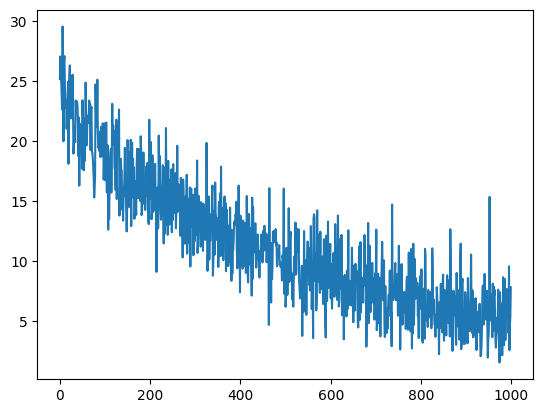

In [ ]:

plt.plot(hist)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist)

In [ ]:
res=0
loss=0
gcnn.eval()
for i in range(3700):
  pr1=Data(x=protein_embed_1[i],edge_index=protein_1[i],batch=batch_1[i])
  pr2=Data(x=protein_embed_2[i],edge_index=protein_2[i],batch=batch_2[i])
  output = gcnn(pr1,pr2).detach()
  loss+=np.abs((labels[i])-output.item())**2
  pred= (output.item()>0.5)
  res+=labels[i].item() == pred

print(res/3700)

0.812972972972973


In [ ]:
!cp ./*.pkl ./drive/MyDrive

In [ ]:
torch.save(gcnn.state_dict(),'gcnn.pth')

In [ ]:
model=GCNN()
model.load_state_dict(torch.load('gcnn.pth'))
print(model)

GCNN Loaded
GCNN(
  (pro1_conv1): GCNConv(7, 7)
  (pro1_fc1): Linear(in_features=7, out_features=128, bias=True)
  (pro2_conv1): GCNConv(7, 7)
  (pro2_fc1): Linear(in_features=7, out_features=128, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0, inplace=False)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)


#Part two